<a href="https://colab.research.google.com/github/GIT4MR/Plant_Disease_Detection/blob/main/Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plant-village-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3715383%2F6437848%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T112040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D85e05206c893aefc4afb0fde04ff97284d2c8e2bd8b62c9301ce04143044e1ea4a00f63ea504497a479471729203a2e10535ad3a1e9eb41cf8e0ae5614f7a7962fb84e72132c47e7496b67dab7224d4ca6a88f79504d46ac3cb757ce7fb2d9e8c3b55f63401b441ef381e31fae7d43af89139ab1c4f32b9dd7ab560306dc7997ce8f8aa375da10421283465e9d7d5fece39279b9384595385710438fefbe511c7ab95431216a14e7e809b888585e013aa078a2d3e785c8460fa39fad8975994cab117c2d8049faa31ed24c324ee4414b6b5348f6c22f64226ca8589e98c5d1fe13fddf6538086a439f6083b8abd4ba4cc1c2e9599f9ab89b6d6f7c4ea4f088bf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint


In [ ]:
directory_root = "../input/plant-village-dataset/PlantVillageDataset/train_val_test/train"
print(len(listdir(directory_root)))

15


In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for single_plant_disease_image in plant_disease_folder_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_folder_list.remove(single_plant_disease_image)

        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [ ]:
img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))

                                          image_path  \
0  ../input/plant-village-dataset/PlantVillageDat...   
1  ../input/plant-village-dataset/PlantVillageDat...   
2  ../input/plant-village-dataset/PlantVillageDat...   
3  ../input/plant-village-dataset/PlantVillageDat...   
4  ../input/plant-village-dataset/PlantVillageDat...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  
14436


In [ ]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,image_path,label,labels_integer
14431,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14432,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14433,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14434,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14435,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14


In [ ]:
img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.ANTIALIAS)
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)

print(len(list_vectors))

/tmp/ipykernel_32/2472196027.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, PIL.Image.ANTIALIAS)


14436


In [ ]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

(14436, 64, 64, 3)


In [ ]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=15)
print(Y.shape, Y_one_hot.shape)

(14436,) (14436, 15)


In [ ]:
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)

In [ ]:
x_npz = np.load("x_images_arrayscnn.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']

print(X.shape)

(14436, 64, 64, 3)


In [ ]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]


print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(11548, 64, 64, 3) (1444, 64, 64, 3) (1444, 64, 64, 3) (11548, 15) (1444, 15) (1444, 15)


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = 15

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation_3 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 activation_4 (Activation)   (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [ ]:
best_model_file = "disease_selected_100.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
results = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 1.9000 - accuracy: 0.4028
Epoch 1: val_loss improved from inf to 1.18175, saving model to disease_selected_100.h5
181/181 [==============================] - 74s 401ms/step - loss: 1.9000 - accuracy: 0.4028 - val_loss: 1.1818 - val_accuracy: 0.6371
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 1.1858 - accuracy: 0.6221
Epoch 2: val_loss improved from 1.18175 to 0.85126, saving model to disease_selected_100.h5
181/181 [==============================] - 73s 403ms/step - loss: 1.1858 - accuracy: 0.6221 - val_loss: 0.8513 - val_accuracy: 0.7244
Epoch 3/50
181/181 [==============================] - ETA: 0s - loss: 0.9456 - accuracy: 0.6924
Epoch 3: val_loss improved from 0.85126 to 0.70472, saving model to disease_selected_100.h5
181/181 [==============================] - 73s 404ms/step - loss: 0.9456 - accuracy: 0.6924 - val_loss: 0.7047 - val_accuracy: 0.7708
Epoch 4/50
181/181 [

In [ ]:
model.evaluate(X_test, Y_test)

46/46 [==============================] - 3s 63ms/step - loss: 0.1879 - accuracy: 0.9377


[0.187885120511055, 0.9376731514930725]

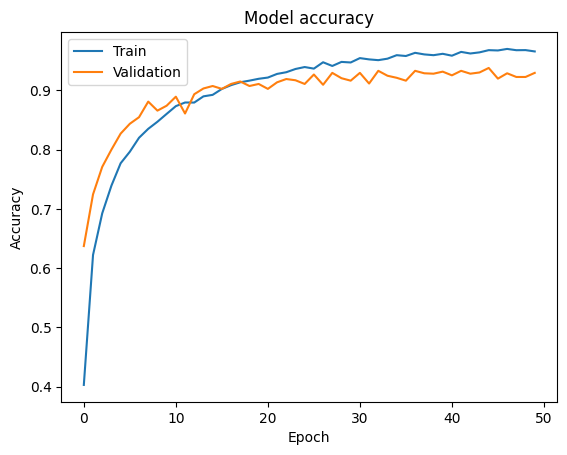

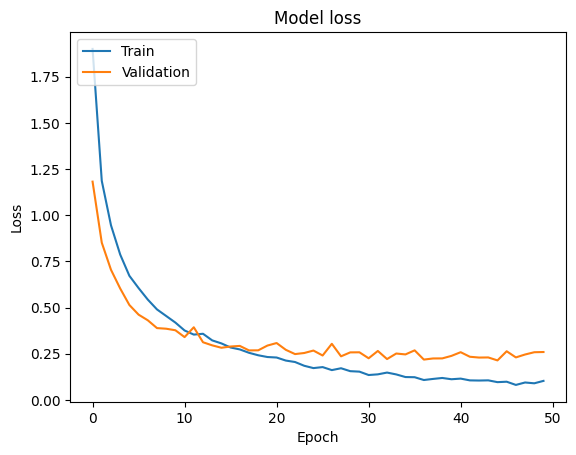

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])  # Use 'accuracy' instead of 'acc'
plt.plot(results.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


46/46 [==============================] - 2s 46ms/step


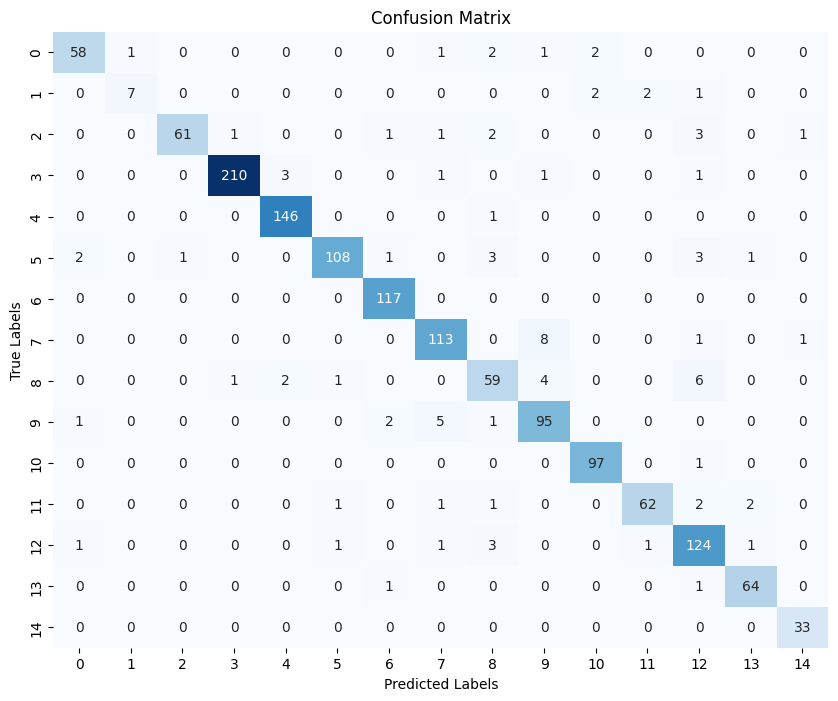

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted probabilities for each class
Y_pred_probabilities = model.predict(X_test)

# Convert predicted probabilities to class labels
Y_pred = np.argmax(Y_pred_probabilities, axis=1)

# Convert one-hot encoded true labels back to categorical labels
Y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [ ]:
best_model = load_model(best_model_file)


# def preprocess_image(image_path):
#     img = Image.open(image_path)
#     size = (64, 64)
#     img = img.resize(size, PIL.Image.ANTIALIAS)
#     img_array = np.array(img)
#     img_array = img_array / 255.0
#     img_array = np.expand_dims(img_array, axis=0)
#     return img_array

def preprocess_image(image_path):
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.LANCZOS)  # Use LANCZOS resampling
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


image_path_to_predict = '/kaggle/input/plant-village-dataset/PlantVillageDataset/train_val_test/val/Potato___Early_blight/2fe81ef1-d7ec-4395-b071-c74d5beb4037___RS_Early.B 7242.JPG'
preprocessed_image = preprocess_image(image_path_to_predict)


prediction = best_model.predict(preprocessed_image)


predicted_class = np.argmax(prediction)


predicted_label = img_info.loc[img_info['labels_integer'] == predicted_class, 'label'].values[0]

print(f"Predicted class: {predicted_class}")
print(f"Predicted label: {predicted_label}")

1/1 [==============================] - 0s 102ms/step
Predicted class: 13
Predicted label: Potato___Early_blight
